<a href="https://colab.research.google.com/github/Doctor-batsy/Stock-Price-prediction-using-RNN/blob/main/Forecasting_Stock_Price_using_Recurrent_Neural_Network_(RNN)_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm
from datetime import datetime as dt
import matplotlib.pyplot as plt
!pip install cufflinks
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#### Simple analysis
The two function define here is a classic function that i persenalyy prefere to download data from yahoo finance along with simple analysis for daily return.

In [36]:
def preprocessing(name, start_date=None, end_date=None):
    """
    Preprocesses the financial data from a given file.

    Parameters:
    name (str): The filename of the data file to process.
    start_date (str, optional): The start date for filtering the data.
    end_date (str, optional): The end date for filtering the data.

    Returns:
    DataFrame: A processed pandas DataFrame with financial data.
    """

    df = pd.read_csv(name, delimiter="\t", index_col="<DATE>", parse_dates=True).dropna()

    # Filter the DataFrame based on the provided date range
    if start_date:
        df = df[df.index >= start_date]
    if end_date:
        df = df[df.index <= end_date]

    df.columns = ["open", "high", "low", "close", "volume"]
    df.index.name = "time"
    df = df.iloc[:, :-2]

    return df

In [37]:
def preprocessing_yf(symbol, start_date=None, end_date=None):
    """
    Preprocesses financial data for a given stock symbol using Yahoo Finance.

    Parameters:
    symbol (str): The ticker symbol of the stock to process.
    start_date (str, optional): The start date for downloading the data. Format: 'YYYY-MM-DD'.
    end_date (str, optional): The end date for downloading the data. Format: 'YYYY-MM-DD'.

    Returns:
    DataFrame: A processed pandas DataFrame with financial data.
    """

    # Download the stock data from Yahoo Finance for the specified date range
    df = yf.download(symbol, start=start_date, end=end_date).dropna()

    # Rename columns for better readability
    df.columns = ["open", "high", "low", "close", "adj close", "volume"]

    # Rename the index for consistency
    df.index.name = "time"

    # Uncomment if 'adj close' needs to be removed
    # del df["adj close"]

    return df

Download Apple data

In [38]:
Apple = preprocessing_yf("AAPL", "2019-01-04", "2023-12-29")

[*********************100%%**********************]  1 of 1 completed


In [39]:
Apple

,open,high,low,close,adj close,volume
time,,,,,,
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.575386,234428400
2019-01-07,37.174999,37.207500,36.474998,36.982498,35.496201,219111200
2019-01-08,37.389999,37.955002,37.130001,37.687500,36.172882,164101200
2019-01-09,37.822498,38.632500,37.407501,38.327499,36.787151,180396400
2019-01-10,38.125000,38.492500,37.715000,38.450001,36.904728,143122800
...,...,...,...,...,...,...
2023-12-21,196.100006,197.080002,193.500000,194.679993,194.679993,46482500
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.600006,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,193.050003,28919300


In [40]:
# Calculate daily return for different stocks for the year 2023
daily_return_for_Apple = Apple["adj close"].pct_change()


In [41]:
import cufflinks as cf
# Convert the daily return to a DataFrame for plotting
df = pd.DataFrame(Apple['open'])

# Use Cufflinks to plot
cf.go_offline()  # Enables offline mode for Cufflinks
df.iplot(title = 'Open Price for Apple', yTitle = 'Open Price', xTitle = 'Date')

This important note highlights a potential issue with visualizing complex data, such as joined daily returns, when using online platforms like Google Colab. It suggests that for comprehensive data analysis, especially those that might not render correctly or fully in online notebooks, it is recommended to use a more robust environment like Visual Studio Code (VSCode) with Jupyter Notebook extension. This advice is given considering that the analysis doesn't require extensive computing resources and can be effectively carried out in a local environment like VSCode.

In [42]:
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
cf.go_offline()

In [43]:

open_prices = Apple['open'].values



# Split the Data into training and test sets for apple
split_idx = int(len(open_prices) * 0.95)
train_open_prices = open_prices[:split_idx]
test_open_prices = open_prices[split_idx:]




In [44]:
timesteps = 5

# Function to create sequences
def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:(i + timesteps)])
        y.append(data[i + timesteps])
    return np.array(X), np.array(y)

RECURRENT NEURAL NETWORK (RNN)

A recurrent neural network model is applicable in sequential modeling. We call it recurrent because the model performs repetitive tasks for each
data point in a series, whereby the output value depends on the preceding values. The decision outcomes of the recurrent network at time step t-1
influence the decision outcomes at the last time step t. It maintains a state to reference historical analysis at a given point. The state manages the
information stored in preceding estimates and recurs back into a network with unique input values.

In [45]:
import numpy as np
import pandas as pd
import math
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.initializers import GlorotUniform
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.callbacks import EarlyStopping
from keras.layers import (Dense, Dropout,
                                     Activation, Flatten,
                                     MaxPooling2D, SimpleRNN, BatchNormalization)
from sklearn.model_selection import train_test_split


In [46]:
# Define Xavier (Glorot) initializer
xavier_initializer = GlorotUniform()
model = Sequential()
model.add(SimpleRNN(128, activation='tanh',
                    input_shape=(timesteps, 1),
                    return_sequences=True,
                    kernel_initializer=xavier_initializer))  # Adding Xavier initializer for tackling vanishing gradient in sigmoid function
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'tanh'))
model.add(Flatten())
model.add(Dense(1))


In [47]:
# Define the learning rate
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 2000], [3e-3, 3e-4, 2e-5])

# Create the Adam optimizer with the specified learning rate
adam_optimizer = Adam(learning_rate=lr)

# Compile the model with the Adam optimizer
model.compile(optimizer=adam_optimizer,
              loss='mean_squared_error',
              metrics=['mse'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 5, 128)            16640     
                                                                 
 dropout_2 (Dropout)         (None, 5, 128)            0         
                                                                 
 dense_4 (Dense)             (None, 5, 64)             8256      
                                                                 
 flatten_2 (Flatten)         (None, 320)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 321       
                                                                 
Total params: 25217 (98.50 KB)
Trainable params: 25217 (98.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:

# Create Sequences for training and testing
train_x, train_y = create_sequences(train_open_prices, timesteps)
test_x, test_y = create_sequences(test_open_prices, timesteps)

# Validation set is the same as the test set in this case
validation_x, validation_y = test_x, test_y

In [49]:
# Reshape data for RNN: [samples, timesteps, features]
train_x_reshaped = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
test_x_reshaped = test_x.reshape((test_x.shape[0], test_x.shape[1], 1))

In [50]:
history = model.fit(train_x_reshaped, train_y, batch_size=64, epochs=3000, validation_data=(test_x_reshaped, test_y))

Streaming output truncated to the last 5000 lines.
19/19 [==============================] - 0s 12ms/step - loss: 8.5524 - mse: 8.5524 - val_loss: 22.5869 - val_mse: 22.5869
Epoch 502/3000
19/19 [==============================] - 0s 12ms/step - loss: 8.8098 - mse: 8.8098 - val_loss: 22.4852 - val_mse: 22.4852
Epoch 503/3000
19/19 [==============================] - 0s 12ms/step - loss: 8.5073 - mse: 8.5073 - val_loss: 22.3058 - val_mse: 22.3058
Epoch 504/3000
19/19 [==============================] - 0s 14ms/step - loss: 8.3854 - mse: 8.3854 - val_loss: 22.0430 - val_mse: 22.0430
Epoch 505/3000
19/19 [==============================] - 0s 16ms/step - loss: 8.8795 - mse: 8.8795 - val_loss: 22.0075 - val_mse: 22.0075
Epoch 506/3000
19/19 [==============================] - 1s 37ms/step - loss: 8.3738 - mse: 8.3738 - val_loss: 21.9044 - val_mse: 21.9044
Epoch 507/3000
19/19 [==============================] - 0s 19ms/step - loss: 8.6047 - mse: 8.6047 - val_loss: 21.7783 - val_mse: 21.7783
Epoch


The provided note offers an option to visualize data using either Cufflinks or Matplotlib. You can choose to run the first cell for an interactive plot with Cufflinks or the second cell for a static plot using Matplotlib, depending on your preference or requirements.

In [51]:
# Generate predictions for the test set
test_predictions = model.predict(test_x_reshaped)
mse = mean_squared_error(test_y, test_predictions)
mae = mean_absolute_error(test_y, test_predictions)
r2 = r2_score(test_y, test_predictions)

print(f"  - Mean Squared Error (MSE): {mse:.4f}")
print(f"  - Mean Absolute Error (MAE): {mae:.4f}")
print(f"  - Accuracy: {r2 * 100:.4f}")
print("-------------------------------------------------")

# Flatten the test_predictions if it's not already 1D
test_predictions_flat = test_predictions.flatten()

# Create a DataFrame from test_y and test_predictions
combined_predictions = pd.DataFrame({
    'Actual Values': test_y,
    'Predicted Values': test_predictions_flat
})

# Plot using Cufflinks
cf.go_offline()
fig = combined_predictions.iplot(asFigure=True, title='Test Set: Actual vs Predicted Values')
fig.update_layout(xaxis_title='Time Steps', yaxis_title='Open Price')
fig.show()

2/2 [==============================] - 0s 9ms/step
  - Mean Squared Error (MSE): 5.3871
  - Mean Absolute Error (MAE): 1.9272
  - Accuracy: 93.5301
-------------------------------------------------


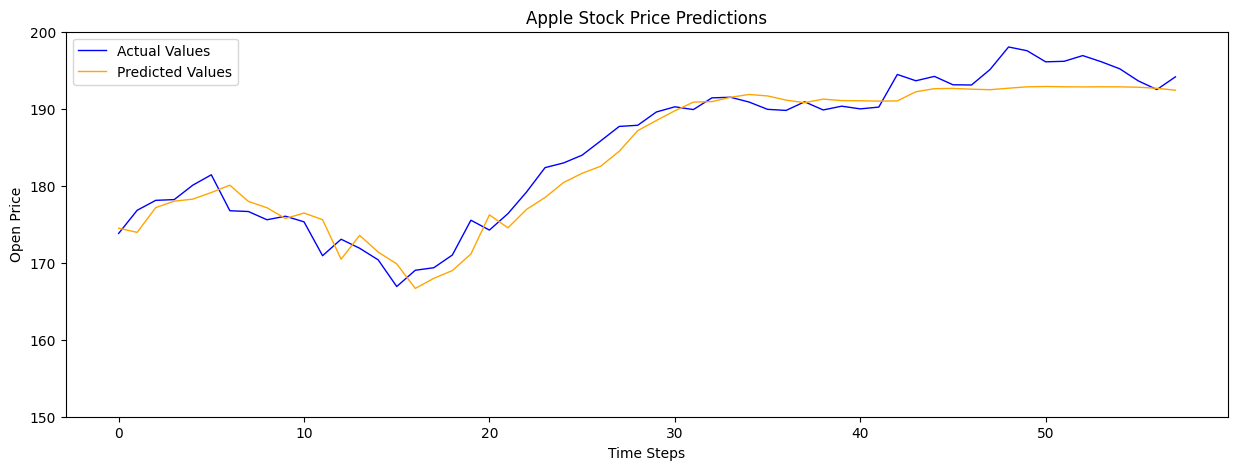

In [52]:
# Plot Predicted vs Actual Values for the Test Set
plt.figure(figsize=(15, 5))
plt.plot(test_y, label='Actual Values', color='blue',linewidth=1)
plt.plot(test_predictions, label='Predicted Values', color='orange', linewidth=1)
plt.title('Apple Stock Price Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Open Price')
plt.ylim(150,200)
plt.legend()
plt.show()